In [ ]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU Available: True
GPU Name: Tesla T4


In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install opendatasets

In [ ]:

import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sarahossammahmoud
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 1.18GB/s]

In [ ]:
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import cv2
import time
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tempfile import TemporaryDirectory
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision import models, transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torch.optim import lr_scheduler

In [ ]:
#Directory path
root_path = '/kaggle/input/brain-tumor-mri-dataset'

#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

#Recommended mean and std
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

#Variables
batch_size = 16
learning_rate = 0.001
num_epochs = 16

Using cuda device


In [ ]:
#Set Transform
data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

In [ ]:
#Load images
image_ds = {x: datasets.ImageFolder(os.path.join(root_path, x), data_transforms) for x in ['Training', 'Testing']}

#Set dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_ds[x], batch_size=batch_size, shuffle=True) for x in ['Training', 'Testing']}

#Check dataset sizes and classes
dataset_sizes = {x: len(image_ds[x]) for x in ['Training', 'Testing']}
class_names = image_ds['Training'].classes

print(f'names of classes: {class_names}')

names of classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
#Plot images
def plotimg(num = 4):
    imgs = {}
    for label in class_names:
        imgs[label] = []
        for img_path in glob.iglob(root_path + '/Training/' + label + '/*'):
            img = cv2.imread(img_path) #get an image
            img = cv2.resize(img, (128, 128)) #resize it
            b, g, r = cv2.split(img) #get the BGR values
            cv2.merge([r, g, b])
            imgs[label].append(img)

    for label in imgs:
        plt.figure(figsize = (16, 9))
        for i in range(num):
            plt.subplot(1, num, i + 1)
            plt.title(label)
            plt.imshow(imgs[label][random.randrange(len(imgs[label]))])


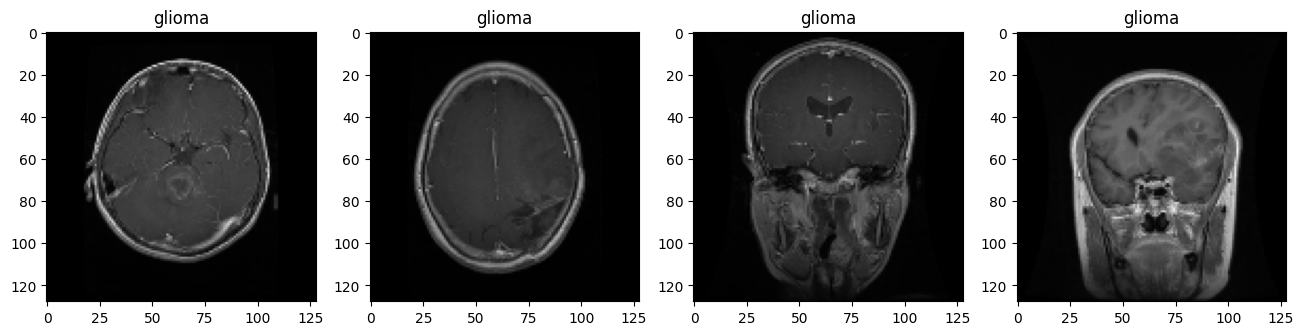

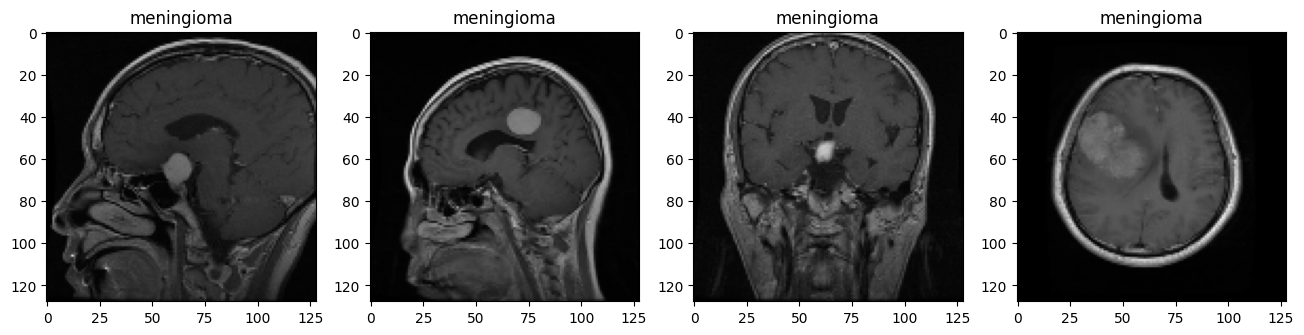

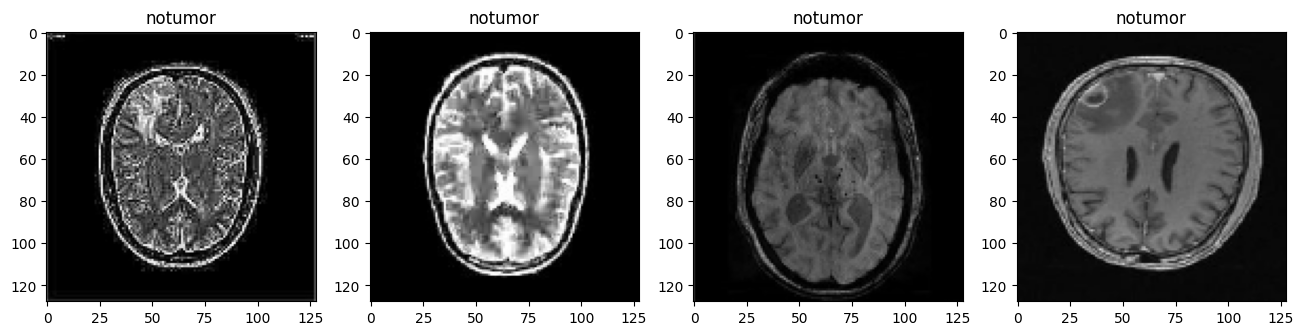

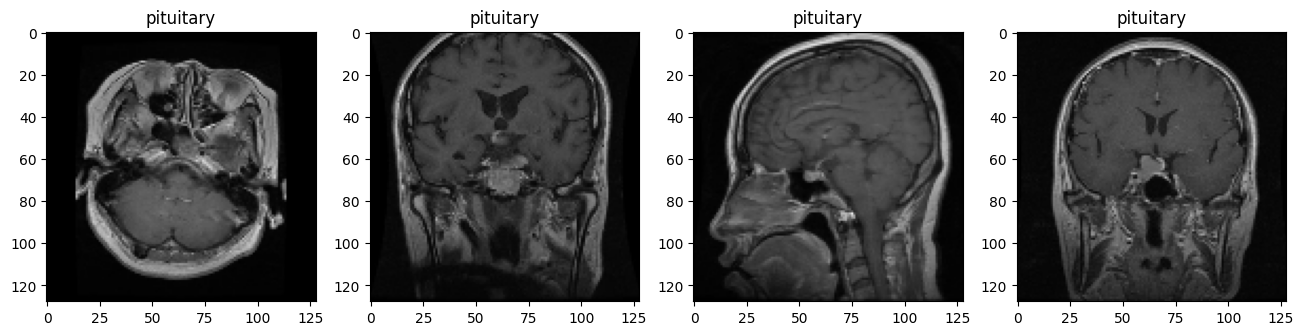

In [ ]:
plotimg()

In [ ]:
def tranfer_learning(model_name):
    if model_name == 'resnet18':
        model = models.resnet18()
        num_ft = model.fc.in_features
        model.fc = nn.Linear(num_ft, 4)
        model = model.to(device)
        return model
    elif model_name == 'densenet121':
        model = models.densenet121()
        num_ft = model.classifier.in_features
        model.classifier = nn.Linear(num_ft, 4)
        model = model.to(device)
        return model
    else:
        print("I don't know that model")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    history = {}
    history['Testing'] = []
    history['Training'] = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and testing phase
            for phase in ['Training', 'Testing']:
                if phase == 'Training':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Training':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'Training':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.to(torch.float) / dataset_sizes[phase]
                history[phase].append([epoch_loss, epoch_acc])
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'Testing' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model, history

In [ ]:
transfer_models = ['resnet18', 'densenet121']
history = {}
for transfer_model in transfer_models:
    model = tranfer_learning(transfer_model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    model, history[transfer_model] = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=16)

Epoch 0/15
----------
Training Loss: 0.7298 Acc: 0.7139
Testing Loss: 0.7380 Acc: 0.7353

Epoch 1/15
----------
Training Loss: 0.5063 Acc: 0.8032
Testing Loss: 1.0224 Acc: 0.6850

Epoch 2/15
----------
Training Loss: 0.4116 Acc: 0.8417
Testing Loss: 0.5354 Acc: 0.7849

Epoch 3/15
----------
Training Loss: 0.3279 Acc: 0.8787
Testing Loss: 0.4137 Acc: 0.8635

Epoch 4/15
----------
Training Loss: 0.2629 Acc: 0.9018
Testing Loss: 0.3303 Acc: 0.8696

Epoch 5/15
----------
Training Loss: 0.2196 Acc: 0.9193
Testing Loss: 0.2333 Acc: 0.9123

Epoch 6/15
----------
Training Loss: 0.1713 Acc: 0.9394
Testing Loss: 0.3837 Acc: 0.8665

Epoch 7/15
----------
Training Loss: 0.0854 Acc: 0.9715
Testing Loss: 0.0925 Acc: 0.9619

Epoch 8/15
----------
Training Loss: 0.0584 Acc: 0.9820
Testing Loss: 0.0891 Acc: 0.9664

Epoch 9/15
----------
Training Loss: 0.0479 Acc: 0.9842
Testing Loss: 0.0673 Acc: 0.9764

Epoch 10/15
----------
Training Loss: 0.0477 Acc: 0.9865
Testing Loss: 0.0621 Acc: 0.9764

Epoch 11/

In [ ]:
def plot_history(history, transfer_model):
    train_loss = [item[0] for item in history['Training']]
    train_acc = [item[1].cpu().numpy() for item in history['Training']]

    test_loss = [item[0] for item in history['Testing']]
    test_acc = [item[1].cpu().numpy() for item in history['Testing']]

    epochs = range(1, len(train_loss) + 1)

    # Plotting
    plt.figure(figsize=(350, 150))
    plt.title(history)
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='train Loss')
    plt.plot(epochs, test_loss, 'ro-', label='val Loss')
    plt.title('Train & Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='train Accuracy')
    plt.plot(epochs, test_acc, 'ro-', label='val Accuracy')
    plt.title('Train & Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.suptitle(transfer_model, fontsize=32, fontweight='bold')

    #plt.tight_layout()
    plt.show()


In [ ]:
for transfer_model in transfer_models:
    plot_history(history[transfer_model], transfer_model)

In [ ]:
torch.save(model, 'AhmedOmarmodel.pth')

In [ ]:
from google.colab import files
files.download('AhmedOmarmodel.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>